# 라이브러리 불러오기 및 초기 설정

In [7]:
# -*- coding: utf-8 -*-

import os
import sys
import platform
import requests
from io import BytesIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

# ---------------------------
# 설정: 출력 옵션, 폰트 (안전하게 처리)
# ---------------------------
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def setup_font(preferred_paths=None):
    """OS에 따라 한글 폰트를 시도해서 설정합니다. 실패하면 기본 폰트 사용."""
    if preferred_paths is None:
        preferred_paths = []
    # Windows 기본
    preferred_paths += [
        'C:/Windows/Fonts/malgun.ttf',  # 맑은 고딕
        '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 리눅스 예시
        '/Library/Fonts/AppleSDGothicNeo.ttc'  # 맥 예시
    ]
    for p in preferred_paths:
        if os.path.exists(p):
            try:
                name = fm.FontProperties(fname=p).get_name()
                plt.rc('font', family=name)
                return
            except Exception:
                continue
    # 실패 시 matplotlib 기본 폰트 사용
    return

setup_font()

# 데이터 로드
깃허브에서 원본 다운받아 전역 변수로 저장

In [2]:
import os
import pandas as pd
import requests

# ==========================================
# 설정: 로컬에서 작업할 때는 True, 깃허브에서 불러올 때는 False
# ==========================================
LOCAL_MODE = True  
DATA_DIR = "./Data_Files"
os.makedirs(DATA_DIR, exist_ok=True)

URLS = {
    "AdmissionsCorePopulatedTable": "https://raw.githubusercontent.com/tashydean/Basic_Health_Care/refs/heads/master/Data_Files/AdmissionsCorePopulatedTable.txt",
    "AdmissionsDiagnosesCorePopulatedTable": "https://raw.githubusercontent.com/tashydean/Basic_Health_Care/refs/heads/master/Data_Files/AdmissionsDiagnosesCorePopulatedTable.txt",
    "LabsCorePopulatedTable": "https://raw.githubusercontent.com/tashydean/Basic_Health_Care/refs/heads/master/Data_Files/LabsCorePopulatedTable.txt",
    "PatientCorePopulatedTable": "https://raw.githubusercontent.com/tashydean/Basic_Health_Care/refs/heads/master/Data_Files/PatientCorePopulatedTable.txt"
}

# ---------------------------
# 유틸리티 함수들
# ---------------------------
def download_to_path(url, dest_path):
    """URL에서 파일을 다운로드."""
    print(f"Downloading from GitHub -> {dest_path}...")
    r = requests.get(url)
    r.raise_for_status()
    with open(dest_path, 'wb') as f:
        f.write(r.content)

def read_table_with_schema(path, schema):
    """지정한 스키마로 파일 읽기."""
    df = pd.read_csv(path, sep='\t', skiprows=1, header=None, names=schema['names'], dtype=str)
    if schema.get('coerce_numeric'):
        for c in schema['coerce_numeric']:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def load_all_data(mode_local=True):
    """로컬 혹은 온라인에서 데이터를 로드하고 전역 변수 생성."""
    data_frames = {}
    schemas = {
        "AdmissionsCorePopulatedTable": {"names": ["PatientID","AdmissionID","AdmissionStartDate","AdmissionEndDate"], "coerce_numeric": []},
        "AdmissionsDiagnosesCorePopulatedTable": {"names": ["PatientID","AdmissionID","PrimaryDiagnosisCode","PrimaryDiagnosisDescription"], "coerce_numeric": []},
        "LabsCorePopulatedTable": {"names": ["PatientID","AdmissionID","LabName","LabValue","LabUnits","LabDateTime"], "coerce_numeric": ["LabValue"]},
        "PatientCorePopulatedTable": {"names": ["PatientID","PatientGender","PatientDateOfBirth","PatientRace","PatientMaritalStatus","PatientLanguage","PatientPopulationPercentageBelowPoverty"], "coerce_numeric": ["PatientPopulationPercentageBelowPoverty"]}
    }
    
    mapping = {
        "AdmissionsCorePopulatedTable": "df_ACPT",
        "AdmissionsDiagnosesCorePopulatedTable": "df_ADCPT",
        "LabsCorePopulatedTable": "df_LCPT",
        "PatientCorePopulatedTable": "df_PCPT"
    }

    for key, url in URLS.items():
        local_path = os.path.join(DATA_DIR, f"{key}.txt")
        
        if mode_local:
            # 로컬 모드: 파일이 있는지 확인만 함
            if not os.path.exists(local_path):
                print(f"⚠️ 로컬 파일이 없습니다. 다운로드를 시도합니다: {key}")
                download_to_path(url, local_path)
        else:
            # 온라인 모드: 항상 다운로드 (혹은 덮어쓰기)
            download_to_path(url, local_path)
            
        df = read_table_with_schema(local_path, schemas[key])
        data_frames[key] = df
        globals()[mapping[key]] = df  # 전역 변수 생성
        
    print("✅ 모든 데이터 로드 완료!")
    return data_frames

# 데이터 로드 실행
data_frames = load_all_data(mode_local=LOCAL_MODE)

✅ 모든 데이터 로드 완료!


# 공통 전처리

In [5]:

# ---------------------------
# 공통 전처리 (날짜, 카테고리, 숫자 등)
# ---------------------------
def common_preprocess(dfs):
    """날짜형 변환, 범주형 변환, 숫자 변환을 일괄 처리."""
    date_cols = ['LabDateTime','PatientDateOfBirth','AdmissionStartDate','AdmissionEndDate']
    for key, df in dfs.items():
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
    # AdmissionID 범주형(ordered)
    for key, df in dfs.items():
        if 'AdmissionID' in df.columns:
            df['AdmissionID'] = df['AdmissionID'].astype('category').cat.as_ordered()
    # 인구통계 범주형
    cat_cols = ['PatientGender','PatientRace','PatientMaritalStatus','PatientLanguage','PrimaryDiagnosisCode','LabName']
    for key, df in dfs.items():
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')
    # 빈곤율 숫자 변환
    for key, df in dfs.items():
        if 'PatientPopulationPercentageBelowPoverty' in df.columns:
            df['PatientPopulationPercentageBelowPoverty'] = pd.to_numeric(df['PatientPopulationPercentageBelowPoverty'], errors='coerce')

common_preprocess(data_frames)

# 각 DataFrame을 전역 변수로 다시 바인딩 (편의)
df_PCPT = globals().get('df_PCPT')
df_ACPT = globals().get('df_ACPT')
df_ADCPT = globals().get('df_ADCPT')
df_LCPT = globals().get('df_LCPT')

# ---------------------------
# 일반적인 EDA 유틸 (원본 코드의 출력 포맷을 유지)
# ---------------------------
def general_overview(df, name):
    print(f"\n------------------------ {name} 데이터프레임 기초 분석 시작 ------------------------")
    # 1. 데이터 타입
    print(df.dtypes)
    # 2. 결측치
    print("결측치 개수 : ")
    print(df.isnull().sum())
    # 3. head, describe, 중복 등
    print(df.head())
    print(df.describe(include='all', datetime_is_numeric=True))
    print('중복된 행 수:', df.duplicated().sum())
    print('중복 행 예시 : ')
    if df.duplicated().sum() > 0:
        print(df[df.duplicated()].head())
    else:
        print("중복 없음")

# 원본에서 했던 기본 EDA (모든 df에 대해)
for key, df in data_frames.items():
    general_overview(df, key)


------------------------ AdmissionsCorePopulatedTable 데이터프레임 기초 분석 시작 ------------------------
PatientID                     object
AdmissionID                 category
AdmissionStartDate    datetime64[ns]
AdmissionEndDate      datetime64[ns]
dtype: object
결측치 개수 : 
PatientID             0
AdmissionID           0
AdmissionStartDate    0
AdmissionEndDate      0
dtype: int64
                              PatientID AdmissionID      AdmissionStartDate  \
0  7A025E77-7832-4F53-B9A7-09A3F98AC17E           7 2011-10-12 14:55:02.027   
1  DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741           1 1993-02-11 18:57:04.003   
2  DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741           2 2002-11-28 19:06:31.117   
3  DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741           3 2011-07-19 18:42:45.287   
4  886B5885-1EE2-49F3-98D5-A2F02EB8A9D4           1 1994-12-03 22:20:46.077   

         AdmissionEndDate  
0 2011-10-22 01:16:07.557  
1 1993-02-24 17:22:29.713  
2 2002-12-04 19:14:40.797  
3 2011-07-25 04:57:42.053  
4 1994-1

4                                    18.20  
                                   PatientID PatientGender  \
count                                    100           100   
unique                                   100             2   
top     C60FE675-CA52-4C55-A233-F4B27E94987F        Female   
freq                                       1            52   
mean                                     NaN           NaN   
min                                      NaN           NaN   
25%                                      NaN           NaN   
50%                                      NaN           NaN   
75%                                      NaN           NaN   
max                                      NaN           NaN   
std                                      NaN           NaN   

                   PatientDateOfBirth PatientRace PatientMaritalStatus  \
count                             100         100                  100   
unique                            NaN           4             

# 각 데이터셋 EDA
## Patient EDA
    - 범주형 : 성별, 인종, 결혼여부, 언어
    - 수치형 : 가난도

=== df_PCPT 단변수 분석 (PatientID 제외) ===
📊 분석 대상 (총 6개 컬럼):
  범주형 (4개): ['PatientGender', 'PatientRace', 'PatientMaritalStatus', 'PatientLanguage']
  수치형 (1개): ['PatientPopulationPercentageBelowPoverty']


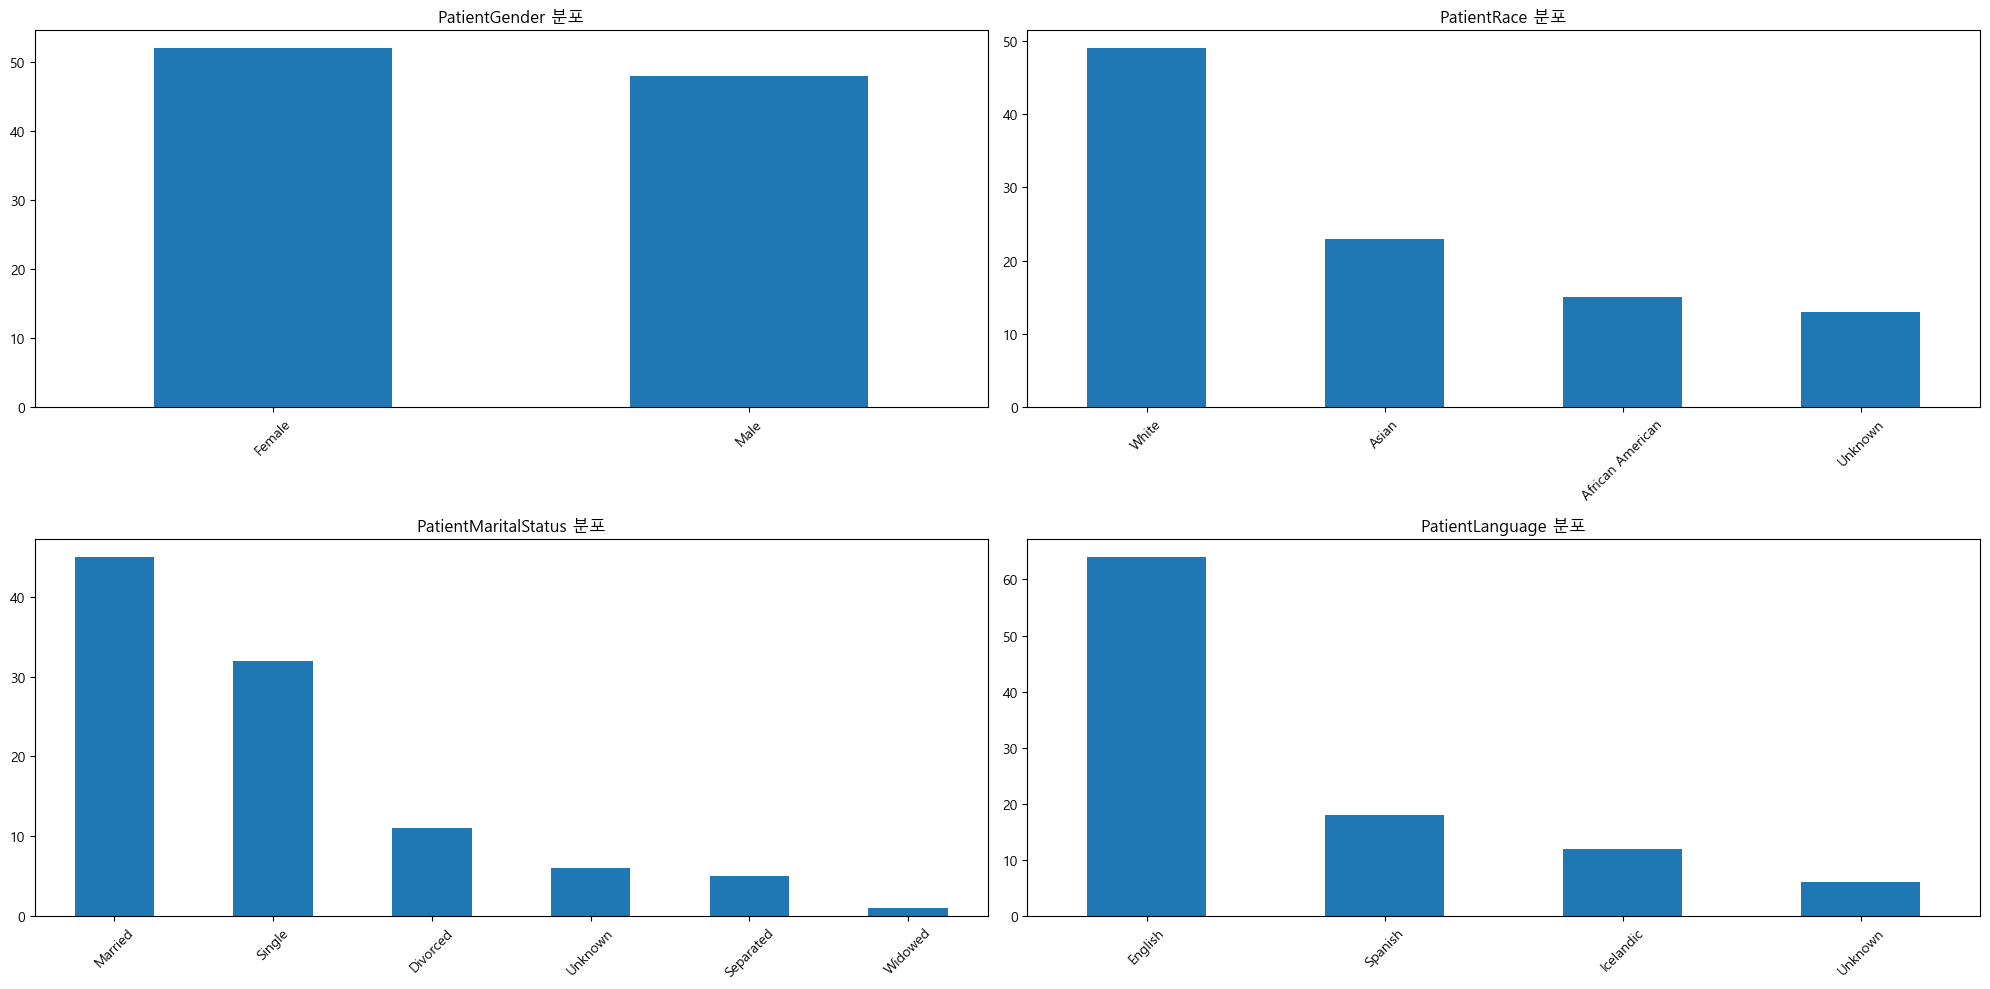

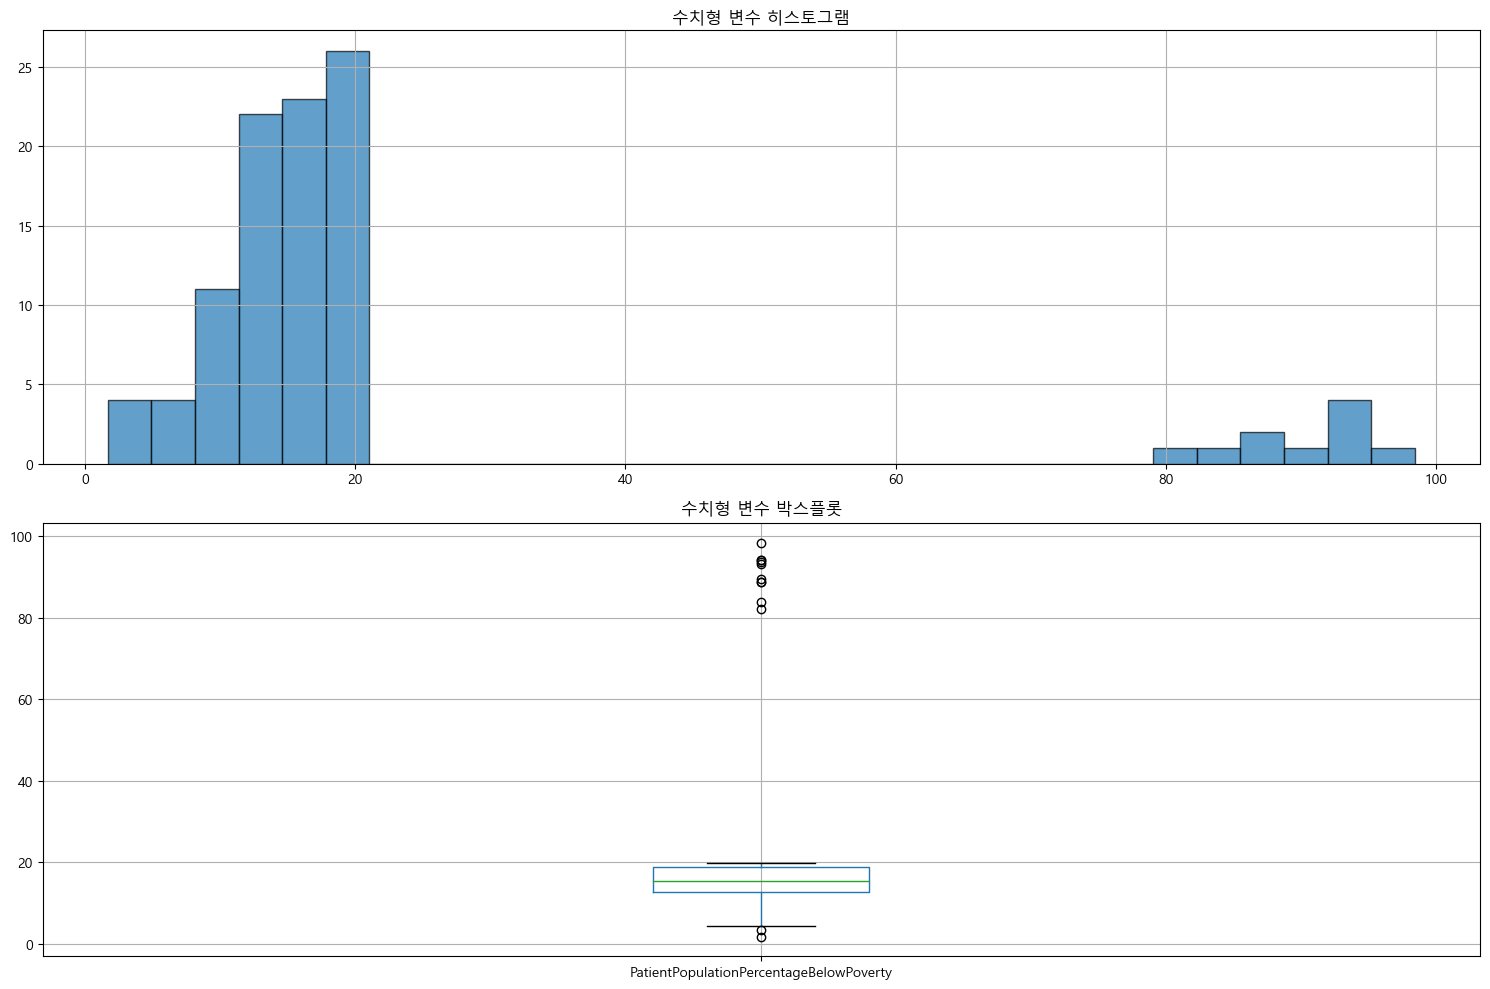

=============== 단변수 분포 요약 ===============

PatientGender:
Female    52
Male      48
Name: PatientGender, dtype: int64

PatientRace:
White               49
Asian               23
African American    15
Unknown             13
Name: PatientRace, dtype: int64

PatientMaritalStatus:
Married      45
Single       32
Divorced     11
Unknown       6
Separated     5
Widowed       1
Name: PatientMaritalStatus, dtype: int64

PatientLanguage:
English      64
Spanish      18
Icelandic    12
Unknown       6
Name: PatientLanguage, dtype: int64

PatientPopulationPercentageBelowPoverty:
count    100.000000
mean      22.102500
std       23.327656
min        1.700000
25%       12.702500
50%       15.435000
75%       18.687500
max       98.400000
Name: PatientPopulationPercentageBelowPoverty, dtype: float64


In [8]:
# ---------------------------
# Patient EDA (원본 함수 재구성)
# ---------------------------
def safe_univariate_eda(df, exclude_cols=['PatientID']):
    """원본과 동일한 단변수 EDA (플롯 + 텍스트)"""
    exclude_cols = set(exclude_cols)
    all_cols = [col for col in df.columns if col not in exclude_cols]
    cat_cols = [col for col in df.select_dtypes(include=['category', 'object']).columns if col not in exclude_cols]
    num_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in exclude_cols]

    print(f"📊 분석 대상 (총 {len(all_cols)}개 컬럼):")
    print(f"  범주형 ({len(cat_cols)}개): {cat_cols}")
    print(f"  수치형 ({len(num_cols)}개): {num_cols}")

    # 범주형 플롯 (원본과 유사)
    if cat_cols:
        n_cats = len(cat_cols)
        ncols = max(2, (n_cats + 1)//2)
        fig, axes = plt.subplots(2, ncols, figsize=(20, 10))
        axes = axes.flatten()
        for i, col in enumerate(cat_cols):
            if i < len(axes):
                df[col].value_counts().plot.bar(ax=axes[i], rot=45)
                axes[i].set_title(f'{col} 분포')
                axes[i].tick_params(axis='x', rotation=45)
        for i in range(len(cat_cols), len(axes)):
            fig.delaxes(axes[i])
        plt.tight_layout()
        plt.show()

    # 수치형 플롯 (히스토, 박스)
    if num_cols:
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        df[num_cols].hist(ax=axes[0], bins=30, edgecolor='black', alpha=0.7)
        axes[0].set_title('수치형 변수 히스토그램')
        df.boxplot(column=num_cols, ax=axes[1])
        axes[1].set_title('수치형 변수 박스플롯')
        plt.tight_layout()
        plt.show()
        
    # 텍스트 요약
    print("=============== 단변수 분포 요약 ===============")
    for col in cat_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())
    for col in num_cols:
        print(f"\n{col}:")
        print(df[col].describe())

print("=== df_PCPT 단변수 분석 (PatientID 제외) ===")
safe_univariate_eda(df_PCPT)


    - 이변량 분석

=== df_PCPT 최종 3개 조합 이변량 분석 ===
🎯 핵심 3개 이변량 분석 (인종×언어 포함)

--- 1. 성별 × 결혼상태 ---


<Figure size 1200x600 with 0 Axes>

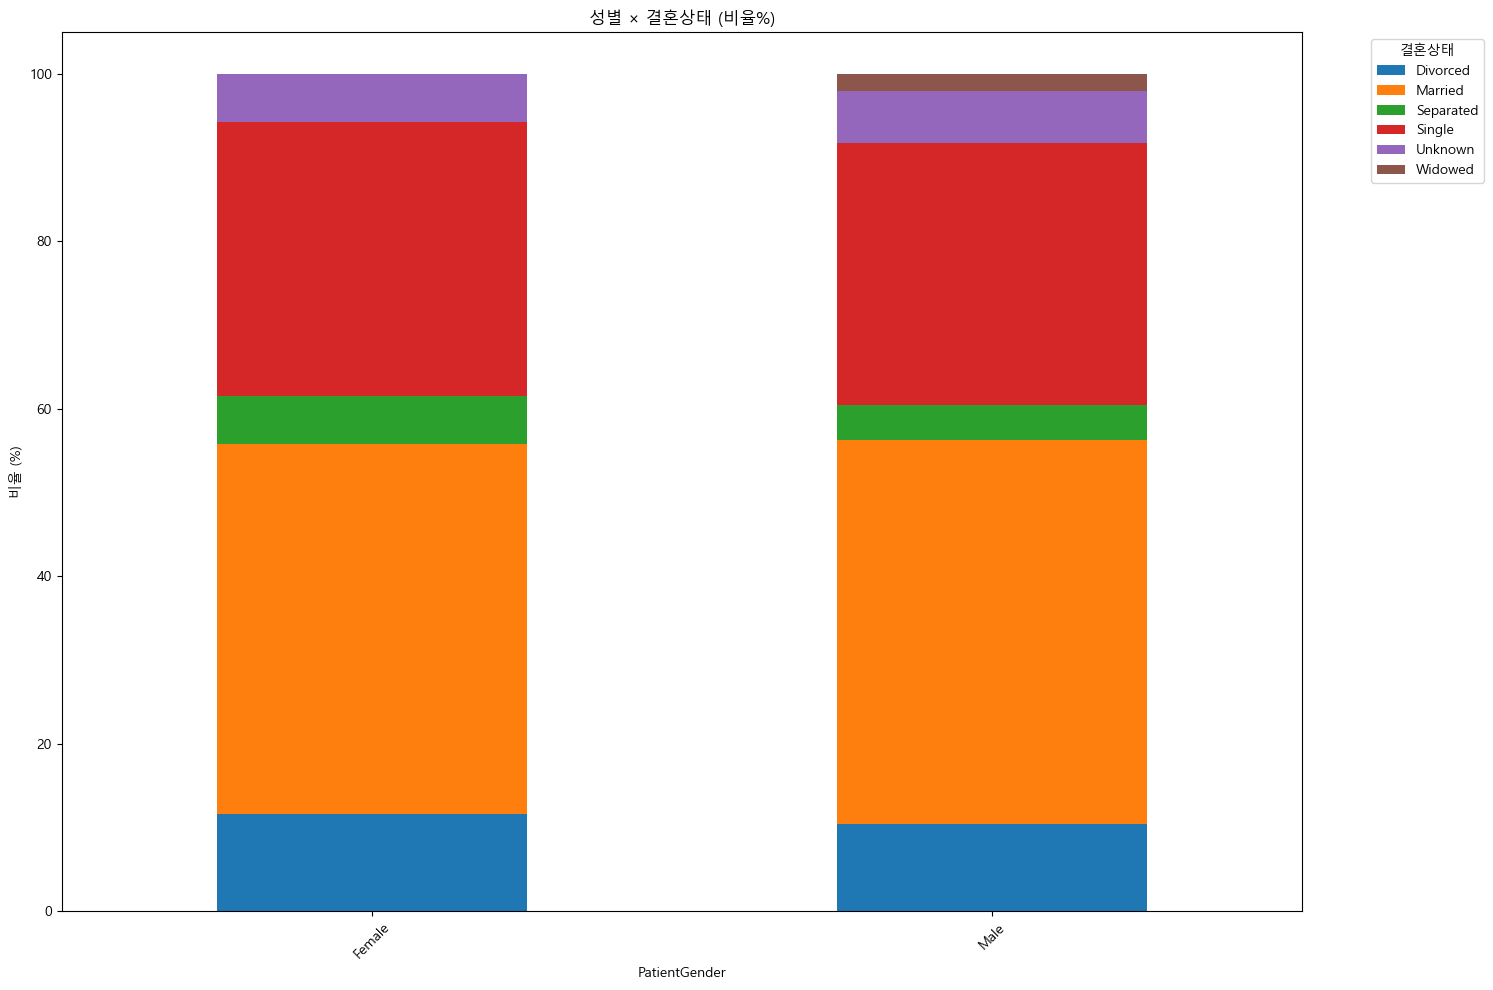

PatientMaritalStatus  Divorced  Married  Separated  Single  Unknown  Widowed
PatientGender                                                               
Female                    0.12     0.44       0.06    0.33     0.06     0.00
Male                      0.10     0.46       0.04    0.31     0.06     0.02

--- 2. 인종 × 언어 ---


<Figure size 1200x600 with 0 Axes>

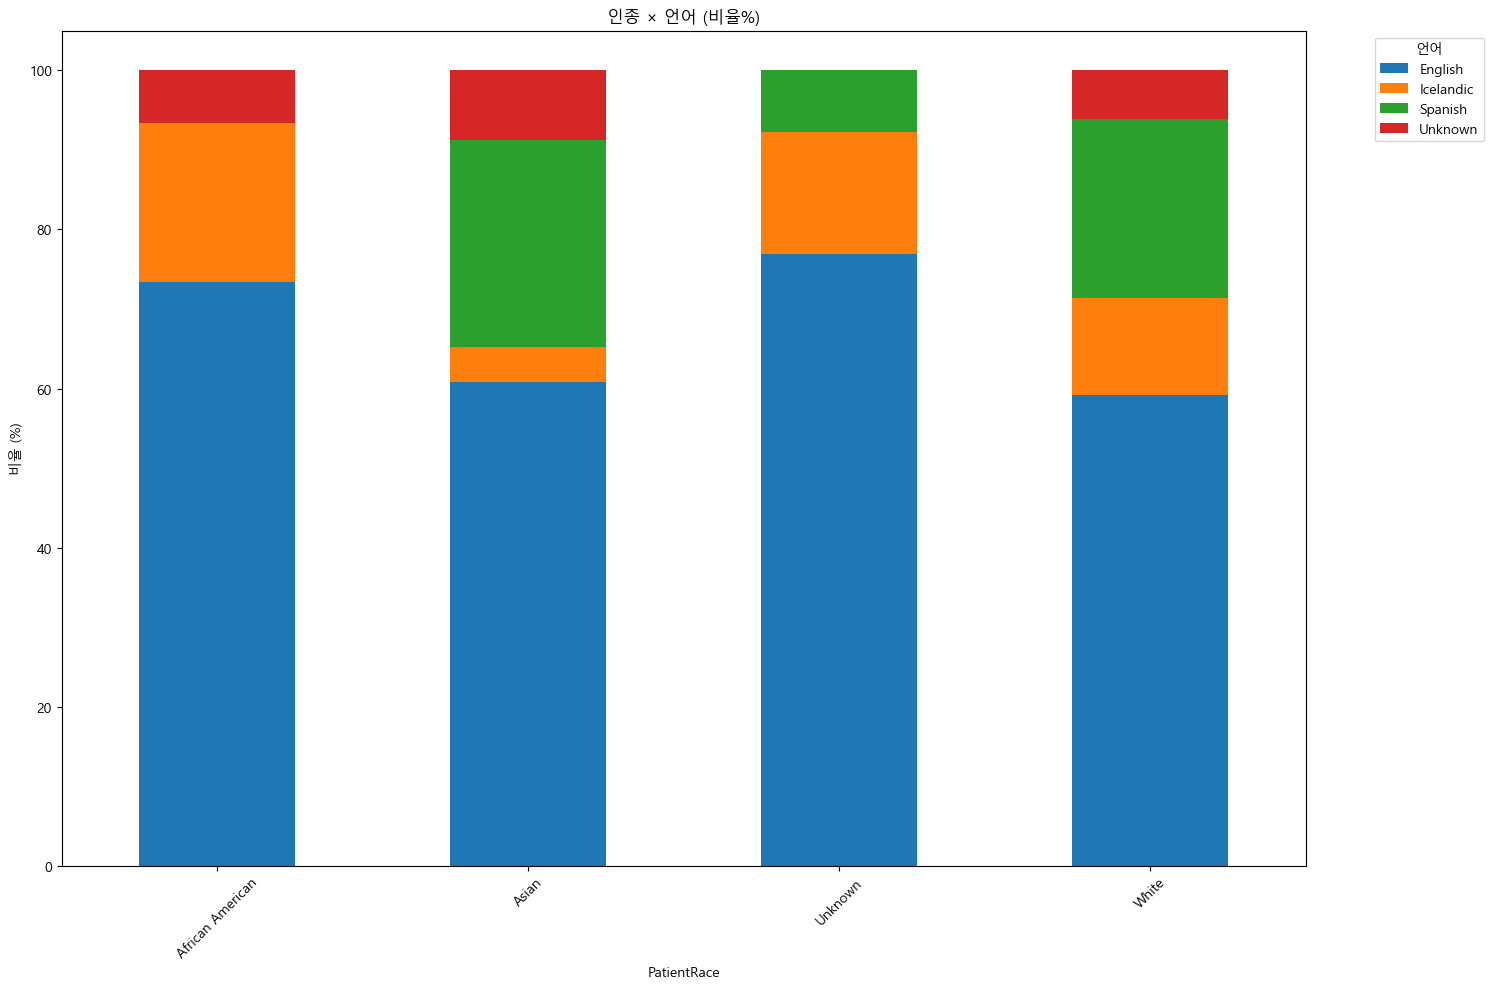

PatientLanguage   English  Icelandic  Spanish  Unknown
PatientRace                                           
African American     0.73       0.20     0.00     0.07
Asian                0.61       0.04     0.26     0.09
Unknown              0.77       0.15     0.08     0.00
White                0.59       0.12     0.22     0.06

--- 3. 빈곤율 × 인종/언어 (1by2 Stripplot) ---


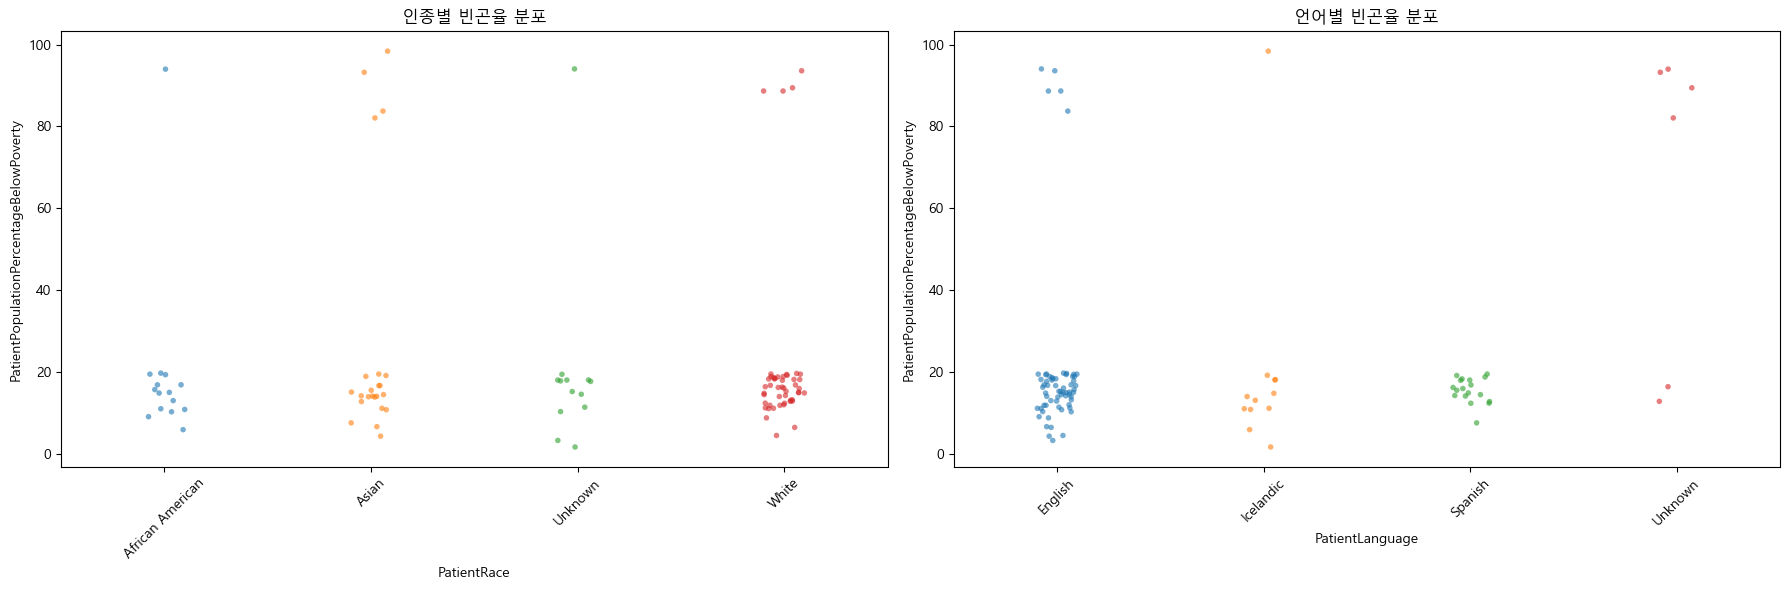

인종별 빈곤율:
                   mean  median  count
PatientRace                           
African American  19.49   15.04     15
Asian             26.84   14.49     23
Unknown           19.99   17.72     13
White             21.24   16.09     49

언어별 빈곤율:
                  mean  median  count
PatientLanguage                      
English          20.41   15.28     64
Icelandic        19.71   13.56     12
Spanish          15.53   15.77     18
Unknown          64.67   85.76      6


In [9]:
def focused_bivariate_eda_final(df):
    """원본의 3개 조합 이변량 분석을 동일하게 재현"""
    print("🎯 핵심 3개 이변량 분석 (인종×언어 포함)")
    # 1. 성별 × 결혼상태
    print("\n--- 1. 성별 × 결혼상태 ---")
    plt.figure(figsize=(12, 6))
    ct = pd.crosstab(df['PatientGender'], df['PatientMaritalStatus'], normalize='index') * 100
    ct.plot.bar(stacked=True)
    plt.title('성별 × 결혼상태 (비율%)')
    plt.ylabel('비율 (%)')
    plt.xticks(rotation=45)
    plt.legend(title='결혼상태', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print(pd.crosstab(df['PatientGender'], df['PatientMaritalStatus'], normalize='index').round(2))

    # 2. 인종 × 언어
    print("\n--- 2. 인종 × 언어 ---")
    plt.figure(figsize=(12, 6))
    ct2 = pd.crosstab(df['PatientRace'], df['PatientLanguage'], normalize='index') * 100
    ct2.plot.bar(stacked=True)
    plt.title('인종 × 언어 (비율%)')
    plt.ylabel('비율 (%)')
    plt.xticks(rotation=45)
    plt.legend(title='언어', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print(pd.crosstab(df['PatientRace'], df['PatientLanguage'], normalize='index').round(2))

    # 3. 빈곤율 × 인종/언어 (stripplot 1by2)
    print("\n--- 3. 빈곤율 × 인종/언어 (1by2 Stripplot) ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    sns.stripplot(data=df, x='PatientRace', y='PatientPopulationPercentageBelowPoverty', alpha=0.6, size=4, ax=ax1)
    ax1.set_title('인종별 빈곤율 분포')
    ax1.tick_params(axis='x', rotation=45)
    sns.stripplot(data=df, x='PatientLanguage', y='PatientPopulationPercentageBelowPoverty', alpha=0.6, size=4, ax=ax2)
    ax2.set_title('언어별 빈곤율 분포')
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    print("인종별 빈곤율:")
    print(df.groupby('PatientRace')['PatientPopulationPercentageBelowPoverty'].agg(['mean','median','count']).round(2))
    print("\n언어별 빈곤율:")
    print(df.groupby('PatientLanguage')['PatientPopulationPercentageBelowPoverty'].agg(['mean','median','count']).round(2))

print("=== df_PCPT 최종 3개 조합 이변량 분석 ===")
focused_bivariate_eda_final(df_PCPT)

## Admission EDA

=== df_ACPT LOS 업데이트 ===
✅ df_ACPT 업데이트 완료! (LOS만 추가)
입원 건수: 372건 | 환자 수: 100명
평균 LOS: 11.07일

=== 입원 EDA 실행 (category 완벽 대응) ===


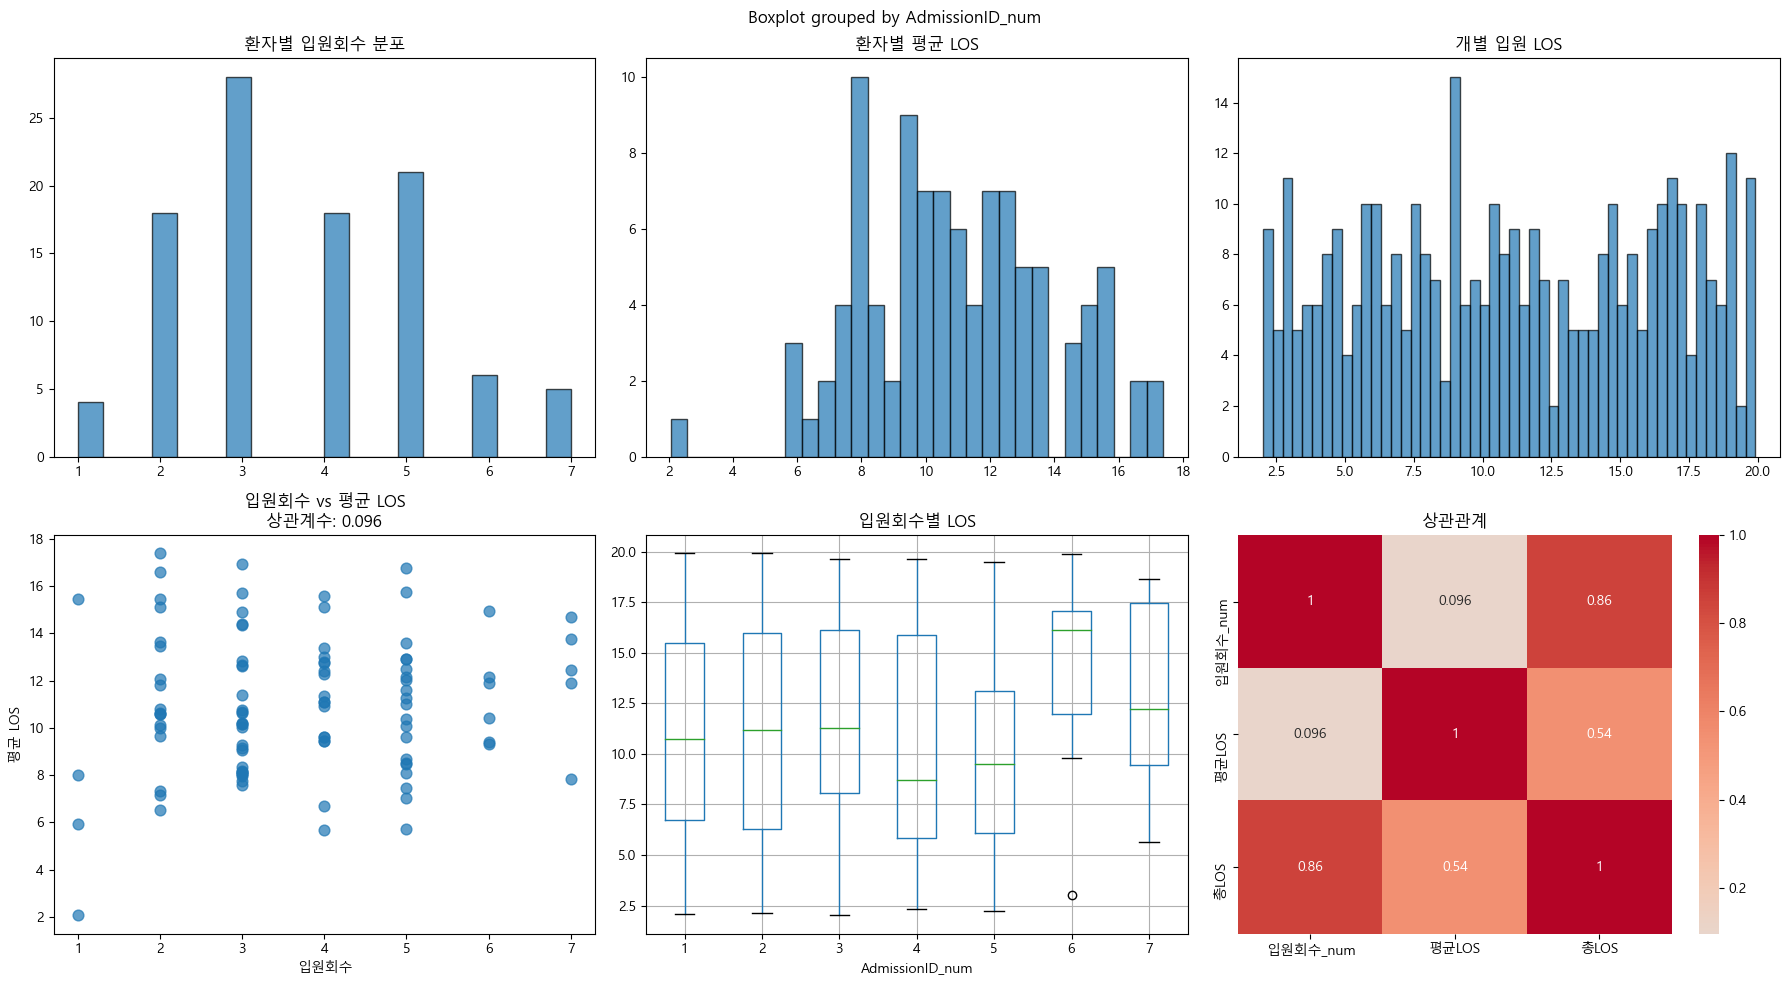

📊 상관계수 (입원회수-평균LOS): 0.096

🎯 입원 데이터 분석 요약
총 입원 건수: 372건
환자 수: 100명
최대 입원회수: 7회
평균 LOS: 11.07일
재입원 환자: 96.0%


In [10]:
# ---------------------------
# Admission EDA (LOS 계산 포함) - 원본 로직 유지
# ---------------------------
def update_df_ACPT_los(df_ACPT):
    df = df_ACPT.copy()
    df['AdmissionStartDate'] = pd.to_datetime(df['AdmissionStartDate'], errors='coerce')
    df['AdmissionEndDate'] = pd.to_datetime(df['AdmissionEndDate'], errors='coerce')
    df['LOS_days'] = (df['AdmissionEndDate'] - df['AdmissionStartDate']).dt.total_seconds() / (24*3600)
    df['입원_연도'] = df['AdmissionStartDate'].dt.year
    df['입원_월'] = df['AdmissionStartDate'].dt.month
    df_clean = df[(df['LOS_days'] > 0) & (df['LOS_days'] < 365)].copy()
    # 원본 data_frames 업데이트 (원본 코드와 동일 행동)
    data_frames['AdmissionsCorePopulatedTable'] = df_clean
    print(f"✅ df_ACPT 업데이트 완료! (LOS만 추가)")
    print(f"입원 건수: {len(df_clean):,}건 | 환자 수: {df_clean['PatientID'].nunique():,}명")
    print(f"평균 LOS: {df_clean['LOS_days'].mean():.2f}일")
    return df_clean

def admission_eda(df_ACPT):
    df = df_ACPT.copy()
    # category -> int (plot 용)
    df_plot = df.copy()
    try:
        df_plot['AdmissionID_num'] = df_plot['AdmissionID'].astype(int)
    except Exception:
        # cat이지만 숫자형 변환이 실패하면 범주별 코드 사용
        df_plot['AdmissionID_num'] = pd.Categorical(df_plot['AdmissionID']).codes

    # 환자별 집계
    patient_summary = df.groupby('PatientID').agg({
        'AdmissionID': 'max',
        'LOS_days': ['mean', 'sum']
    }).round(2)
    patient_summary.columns = ['입원회수','평균LOS','총LOS']
    patient_summary['입원회수_num'] = patient_summary['입원회수'].astype(int)

    # 6개 그래프 (원본 그대로)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    axes[0,0].hist(patient_summary['입원회수_num'], bins=20, edgecolor='black', alpha=0.7)
    axes[0,0].set_title('환자별 입원회수 분포')

    axes[0,1].hist(patient_summary['평균LOS'], bins=30, edgecolor='black', alpha=0.7)
    axes[0,1].set_title('환자별 평균 LOS')

    axes[0,2].hist(df['LOS_days'], bins=50, edgecolor='black', alpha=0.7)
    axes[0,2].set_title('개별 입원 LOS')

    corr = patient_summary['입원회수_num'].corr(patient_summary['평균LOS'])
    axes[1,0].scatter(patient_summary['입원회수_num'], patient_summary['평균LOS'], alpha=0.7, s=60)
    axes[1,0].set_title(f'입원회수 vs 평균 LOS\n상관계수: {corr:.3f}')
    axes[1,0].set_xlabel('입원회수'); axes[1,0].set_ylabel('평균 LOS')

    try:
        df_plot.boxplot(column='LOS_days', by='AdmissionID_num', ax=axes[1,1])
        axes[1,1].set_title('입원회수별 LOS')
    except Exception:
        axes[1,1].text(0.5, 0.5, '박스플롯 생성 실패', ha='center')

    corr_df = patient_summary[['입원회수_num','평균LOS','총LOS']].dropna()
    sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
    axes[1,2].set_title('상관관계')

    plt.tight_layout()
    plt.show()

    print(f"📊 상관계수 (입원회수-평균LOS): {corr:.3f}")
    return patient_summary

print("=== df_ACPT LOS 업데이트 ===")
df_ACPT = update_df_ACPT_los(df_ACPT)

print("\n=== 입원 EDA 실행 (category 완벽 대응) ===")
patient_summary = admission_eda(df_ACPT)

print("\n" + "="*70)
print("🎯 입원 데이터 분석 요약")
print("="*70)
print(f"총 입원 건수: {len(df_ACPT):,}건")
print(f"환자 수: {df_ACPT['PatientID'].nunique():,}명")
try:
    print(f"최대 입원회수: {df_ACPT['AdmissionID'].astype(int).max():,}회")
except Exception:
    print("최대 입원회수: (AdmissionID 숫자 변환 불가)")
print(f"평균 LOS: {df_ACPT['LOS_days'].mean():.2f}일")
print(f"재입원 환자: {(df_ACPT.groupby('PatientID')['AdmissionID'].max().astype(int) > 1).mean()*100:.1f}%")

## Diagmosis EDA

In [11]:
# ---------------------------
# Diagnosis EDA (원본과 동일)
# ---------------------------
def diagnosis_eda(df_ADCPT):
    df = df_ADCPT.copy()
    print("🏥 Diagnosis EDA (df_ADCPT only)")
    df['AdmissionID_num'] = df['AdmissionID'].astype(int)
    print("\n① 진단 빈도 Top 10 (Admission 기준)")
    dx_freq = df['PrimaryDiagnosisCode'].value_counts()
    print(dx_freq.head(10))
    code_desc_check = df.groupby('PrimaryDiagnosisCode')['PrimaryDiagnosisDescription'].nunique()
    print("\n④ 진단 코드-설명 1:1 매핑 여부")
    print("✅ 정상" if (code_desc_check == 1).all() else "❌ 불일치 존재")

diagnosis_eda(df_ADCPT)

🏥 Diagnosis EDA (df_ADCPT only)

① 진단 빈도 Top 10 (Admission 기준)
Z22.31     3
E30        2
K57.5      2
J66.1      2
E09.62     2
C40.11     2
I79.0      2
M02.352    2
C18.3      2
C94.32     2
Name: PrimaryDiagnosisCode, dtype: int64

④ 진단 코드-설명 1:1 매핑 여부
✅ 정상


## Labs EDA

🧪 실험실 검사 완전 분석 + 계절성 (기상청 기준)
총 검사: 111,483건 | 기간: 1941~2013

📊 Top 10 검사 품목:
CBC: NEUTROPHILS                 3224
METABOLIC: CARBON DIOXIDE        3218
URINALYSIS: WHITE BLOOD CELLS    3218
CBC: HEMATOCRIT                  3211
CBC: ABSOLUTE NEUTROPHILS        3210
CBC: WHITE BLOOD CELL COUNT      3209
METABOLIC: SODIUM                3207
CBC: MCHC                        3202
METABOLIC: ALBUMIN               3202
METABOLIC: GLUCOSE               3202
Name: LabName, dtype: int64

👥 환자당 평균 검사: 1114.8개 | 검사왕: 2760개

📅 연도별 패턴:
      검사건수  검사종류
Year            
1941   243    35
1942   306    35
1944   352    35
1945   867    35
1947   208    35
1948   407    35
1949   510    35
1950   189    35
1951   153    35
1952    76    34
1953   690    35
1954   315    35
1956   817    35
1959   937    35
1960   384    35
1961   289    35
1962   899    35
1964   693    35
1965  1029    35
1966   162    35
1967  1379    35
1968  1221    35
1970  1429    35
1971   457    35
1972   146    35
1973   78

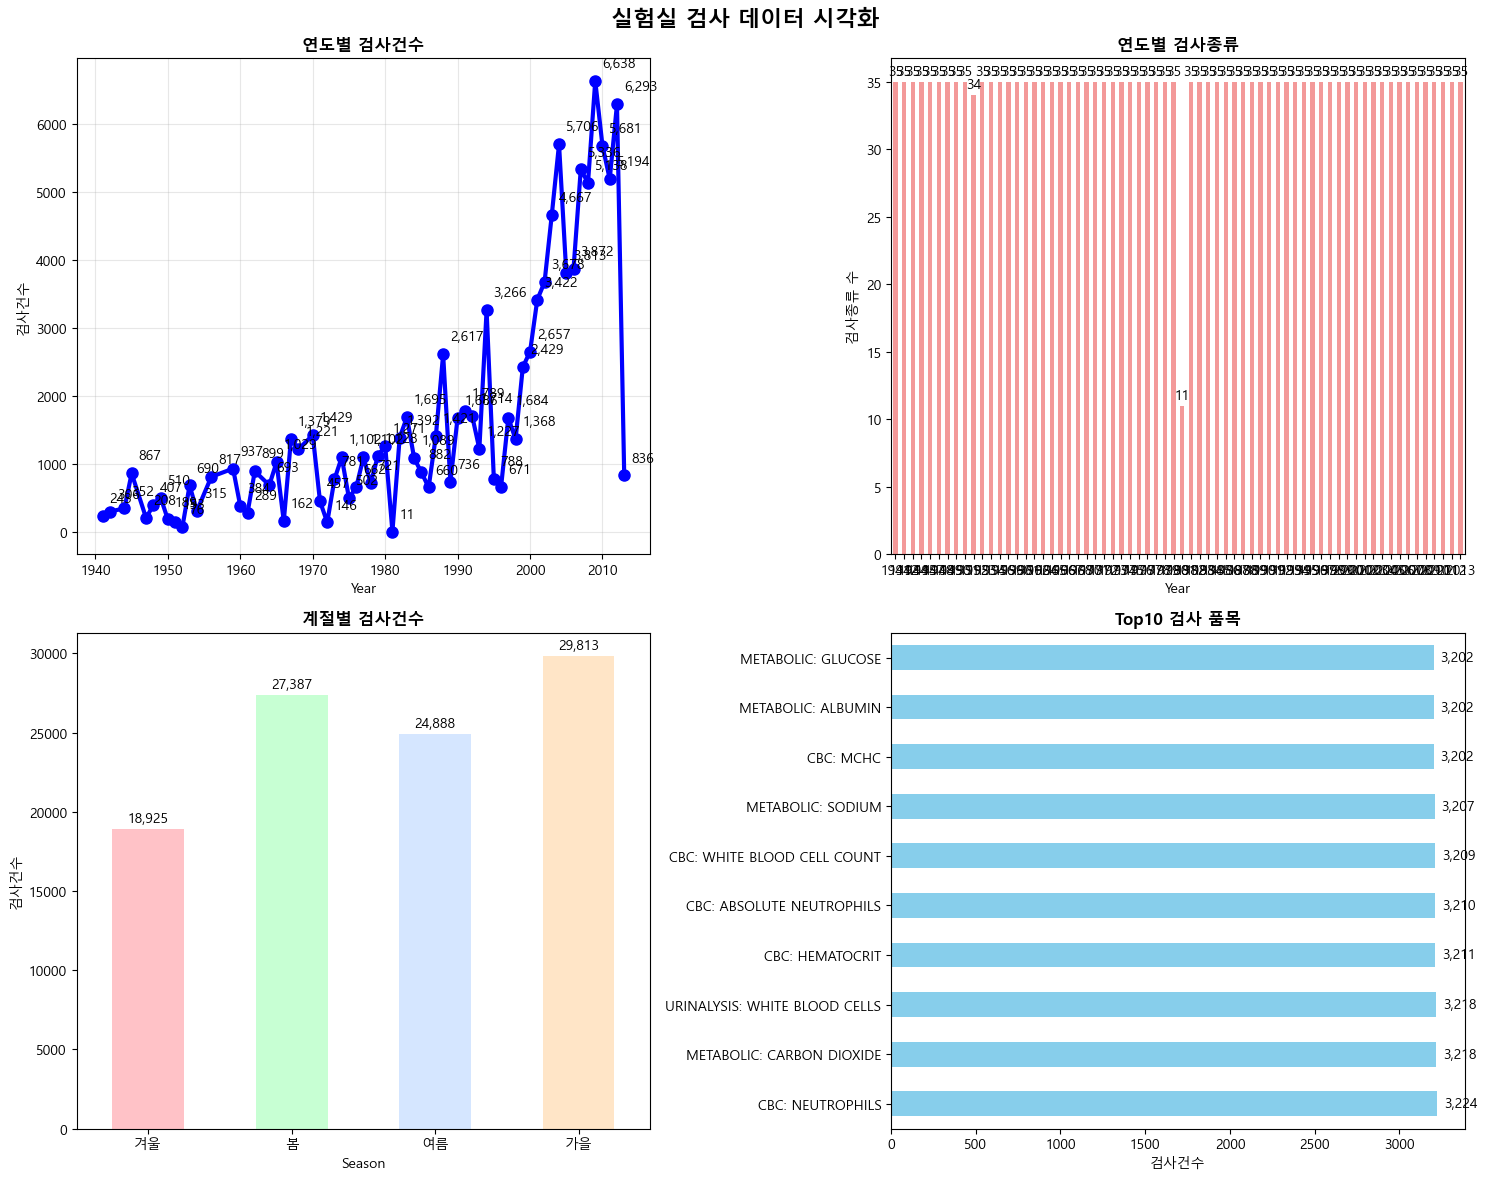


✅ 원본 데이터 업데이트 완료
📅 계절 기준: 겨울(12-2월), 봄(3-5월), 여름(6-8월), 가을(9-11월)


In [12]:
# ---------------------------
# Labs EDA (원본 lab_complete_eda_v4 동일 동작)
# ---------------------------
def lab_complete_eda_v4(df_lab):
    df = df_lab.copy()
    df['LabDateTime'] = pd.to_datetime(df['LabDateTime'], errors='coerce')
    df['Year'] = df['LabDateTime'].dt.year
    df['Month'] = df['LabDateTime'].dt.month
    df['Season'] = pd.cut(df['Month'], bins=[0,3,6,9,12], labels=['겨울','봄','여름','가을'], right=False)
    for col in ['PatientID','AdmissionID','LabName']:
        if col in df.columns:
            df[col] = df[col].astype(str)
    print("🧪 실험실 검사 완전 분석 + 계절성 (기상청 기준)")
    print(f"총 검사: {len(df):,}건 | 기간: {df['Year'].min()}~{df['Year'].max()}")
    top_labs = df['LabName'].value_counts().head(10)
    print("\n📊 Top 10 검사 품목:")
    print(top_labs)
    patient_lab_cnt = df.groupby('PatientID').size()
    avg_tests = patient_lab_cnt.mean(); max_tests = patient_lab_cnt.max()
    print(f"\n👥 환자당 평균 검사: {avg_tests:.1f}개 | 검사왕: {max_tests}개")
    yearly_stats = df.groupby('Year').agg({'LabName':['size','nunique']}).round(0)
    yearly_stats.columns = ['검사건수','검사종류']
    print("\n📅 연도별 패턴:")
    print(yearly_stats)
    if len(yearly_stats) > 1:
        growth_rate = ((yearly_stats['검사종류'].iloc[-1] / yearly_stats['검사종류'].iloc[0]) - 1) * 100
        print(f"   검사종류 증가율: +{growth_rate:.0f}%")
    season_stats = df.groupby('Season').agg({'LabName':['size','nunique']}).round(0).fillna(0)
    season_stats.columns = ['검사건수','검사종류']
    print("\n❄️ 계절별 패턴 (기상청 기준: 가을9-11월, 겨울12-2월):")
    print(season_stats)
    # 시각화 (원본과 동일)
    fig, axes = plt.subplots(2, 2, figsize=(15,12))
    fig.suptitle('실험실 검사 데이터 시각화', fontsize=16, fontweight='bold')
    yearly_stats['검사건수'].plot(ax=axes[0,0], marker='o', linewidth=3, markersize=8, color='blue')
    axes[0,0].set_title('연도별 검사건수', fontweight='bold', fontsize=12); axes[0,0].set_ylabel('검사건수'); axes[0,0].grid(True, alpha=0.3)
    for i, v in enumerate(yearly_stats['검사건수']): axes[0,0].annotate(f'{v:,.0f}', (yearly_stats.index[i], v), xytext=(5, 10), textcoords='offset points', fontsize=10)
    yearly_stats['검사종류'].plot(kind='bar', ax=axes[0,1], color='lightcoral', alpha=0.8)
    axes[0,1].set_title('연도별 검사종류', fontweight='bold', fontsize=12); axes[0,1].set_ylabel('검사종류 수'); axes[0,1].tick_params(axis='x', rotation=0)
    for i, v in enumerate(yearly_stats['검사종류']): axes[0,1].annotate(f'{v:.0f}', (i, v), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)
    season_order = ['겨울','봄','여름','가을']
    season_colors = ['#FFB3BA', '#BAFFC9', '#CBE0FF', '#FFDFBA']
    season_stats.loc[season_order, '검사건수'].plot(kind='bar', ax=axes[1,0], color=season_colors, alpha=0.8)
    axes[1,0].set_title('계절별 검사건수', fontweight='bold', fontsize=12); axes[1,0].set_ylabel('검사건수'); axes[1,0].tick_params(axis='x', rotation=0)
    for i, v in enumerate(season_stats.loc[season_order, '검사건수']): axes[1,0].annotate(f'{v:,.0f}', (i, v), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)
    top_labs.head(10).plot(kind='barh', ax=axes[1,1], color='skyblue')
    axes[1,1].set_title('Top10 검사 품목', fontweight='bold', fontsize=12); axes[1,1].set_xlabel('검사건수')
    for i, v in enumerate(top_labs.head(10)): axes[1,1].annotate(f'{v:,.0f}', (v, i), xytext=(5, 0), textcoords='offset points', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print("\n✅ 원본 데이터 업데이트 완료")
    print("📅 계절 기준: 겨울(12-2월), 봄(3-5월), 여름(6-8월), 가을(9-11월)")

lab_complete_eda_v4(df_LCPT)

## To be Continued...
#### 4개의 데이터셋 각각 EDA 완료
#### 데이터셋 취합 방법 고민 필요
### >> Tabular to Image & Diagnosis Classification